# Subgroup Analysis

Coco Yu  
December 11, 2024

# Housekeeping

## Code status

## Notes

# Set Up

## Set Up Environment

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
algorithms <- params$algorithms
version <- params$version


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──
✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

here() starts at /Users/yujiachen/Desktop/github/study_messages

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))
path_messages <- format_path(str_c("studydata/risk/data_processed/messages"))
path_shared <- format_path(str_c("studydata/risk/data_processed/shared"))


## Data Cleaning

Read in Data

In [ ]:
probs <- 
  read_rds(here::here(path_models, str_c("inner_preds_", version, "_", cv, ".rds"))) |> 
  glimpse()


Rows: 312,174
Columns: 7
$ id_obs          <int> 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.5004720, 0.4995192, 0.4995192, 0.5005576, 0.5005382,…
$ prob_iso        <dbl> 0.07657658, 0.07657658, 0.07657658, 0.07657658, 0.0765…
$ prob_logi       <dbl> 0.09117982, 0.09939817, 0.09939817, 0.09293282, 0.0923…
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…

Rows: 208
Columns: 16
$ dem_1   <dbl> 57, 35, 22, 39, 22, 38, 22, 38, 25, 45, 63, 50, 53, 26, 52, 54…
$ dem_2   <chr> "Male", "Female", "Female", "Male", "Male", "Male", "Female", …
$ dem_3   <chr> "White/Caucasian", "White/Caucasian", "White/Caucasian", "Whit…
$ dem_3_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Filipino and Black", NA, NA, …
$ dem_4   <chr> "No, I am not of Hispanic, Latino, or Spanish origin", "No, I …
$ dem_4_1 <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ dem_5   <chr> "College degree", "2-Year degree", "High school or GED", "Coll…
$ dem_6   <chr> "Unemployed", "Employed", "Employed", "Employed", "Employed", …
$ dem_6_1 <chr> NA, "Full-time", "Full-time", "Full-time", "Part-time", "Full-…
$ dem_7   <dbl> 12000, 36920, 20064, 130000, 5000, 70000, 8000, 57000, 10000, …
$ dem_8   <chr> "Never Married", "Never Married", "Never Married", "Married", …
$ dem2_2  <dbl> 2, 2, 4, 1, 2, 1, 4, 2, 2, 2, 0, 2, 3, 2, 1, 0, 2, 2, 2, 1, 2,…
$ dem2_4  <dbl> 0,

Find demographic groups

In [ ]:
demographics <- labels |> 
  left_join(screen, by = "subid") |> 
  select(-day_start, -day_end, -lapse) |> 
  distinct() |> 
  mutate(
    race = case_when(
      dem_3 == "White/Caucasian" & grepl("No", dem_4) ~ "white",
      dem_3 != "White/Caucasian" | grepl("Yes", dem_4) ~ "non_white"),
    sex = if_else(dem_2 == "Female", "female", "male"),
    age = if_else(dem_1 >= 55, "older", "younger"),
    income = if_else(dem_7 <= .5 * 30000, "below_poverty", "above_poverty")
  ) |> 
  select(-starts_with("dem")) |> 
  glimpse()


Rows: 11,562
Columns: 6
$ subid  <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ id_obs <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ race   <chr> "white", "white", "white", "white", "white", "white", "white", …
$ sex    <chr> "female", "female", "female", "female", "female", "female", "fe…
$ age    <chr> "younger", "younger", "younger", "younger", "younger", "younger…
$ income <chr> "above_poverty", "above_poverty", "above_poverty", "above_pover…

In [ ]:
probs <- probs |> 
  left_join(demographics, by = "id_obs")


### Calculate auROC

In [ ]:
auroc_all <- probs |> 
  group_by(inner_split_num, outer_split_num) |> 
  summarize(auroc = roc_auc_vec(truth = label, estimate = prob_raw))


`summarise()` has grouped output by 'inner_split_num'. You can override using
the `.groups` argument.

In [ ]:
auroc_race <- probs |> 
  group_by(inner_split_num, outer_split_num, race) |> 
  summarize(auroc = roc_auc_vec(truth = label, estimate = prob_raw)) |> 
  ungroup() |> 
  bind_rows(auroc_all |> mutate(race = "all")) |> 
  rename(subgroup = race)


The first warning was:
ℹ In argument: `auroc = roc_auc_vec(truth = label, estimate = prob_raw)`.
ℹ In group 7: `inner_split_num = 1`, `outer_split_num = 4`, `race =
  "non_white"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 50 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

The first warning was:
ℹ In argument: `auroc = roc_auc_vec(truth = label, estimate = prob_raw)`.
ℹ In group 7: `inner_split_num = 1`, `outer_split_num = 4`, `age = "older"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 64 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

The first warning was:
ℹ In argument: `auroc = roc_auc_vec(truth = label, estimate = prob_raw)`.
ℹ In group 166: `inner_split_num = 3`, `outer_split_num = 23`, `income =
  "below_poverty"`.
Caused by warning:
! No event observations were detected in `truth` with event level 'lapse'.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 remaining warnings.

`summarise()` has grouped output by 'inner_split_num', 'outer_split_num'. You
can override using the `.groups` argument.

## Build Model

In [ ]:
bayes_model <- function(df){
  df |> 
    filter(subgroup != "all") |>
    select(c("auroc", "subgroup", "inner_split_num", "outer_split_num")) |> 
    group_by(subgroup) |>
    mutate(repeat_num = inner_split_num,
           fold_num = outer_split_num) |> 
    select(c("auroc", "subgroup", "repeat_num", "fold_num")) |>
    pivot_wider(values_from = c("auroc"), names_from = subgroup) |>
    rename(id = repeat_num, id2 = fold_num) |>
    perf_mod(formula = statistic ~ model + (1 | id2/id),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             # transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             iter = 12000, chains = 4,
             adapt_delta = .99,
             # cores = 4, seed = 12345,
             family = gaussian, verbose = FALSE)
}

bayes_output <- function(pp){
  pp |>
  tidy(seed = 123) |>
  group_by(model) |> 
  summarize(median = quantile(posterior, probs = .5),
            lower = quantile(posterior, probs = .025), 
            upper = quantile(posterior, probs = .975))
}


In [ ]:
if (file.exists(here(path_messages, "pp", "pp_race.rds"))){
  pp_race <- read_rds(here(path_messages, "pp", "pp_race.rds"))
} else{
  pp_race <- bayes_model(auroc_race)
  pp_race |> write_rds(here(path_messages, "pp", "pp_auroc.rds"))
}

if (file.exists(here(path_messages, "pp", "pp_sex.rds"))){
  pp_sex <- read_rds(here(path_messages, "pp", "pp_sex.rds"))
} else{
  pp_sex <- bayes_model(auroc_sex)
  pp_sex |> write_rds(here(path_messages, "pp", "pp_sex.rds"))
}

if (file.exists(here(path_messages, "pp", "pp_age.rds"))){
  pp_age <- read_rds(here(path_messages, "pp", "pp_age.rds"))
} else{
  pp_age <- bayes_model(auroc_age)
  pp_age |> write_rds(here(path_messages, "pp", "pp_age.rds"))
}

if (file.exists(here(path_messages, "pp", "pp_income.rds"))){
  pp_income <- read_rds(here(path_messages, "pp", "pp_income.rds"))
} else{
  pp_income <- bayes_model(auroc_income)
  pp_income |> write_rds(here(path_messages, "pp", "pp_income.rds"))
}


## Plot

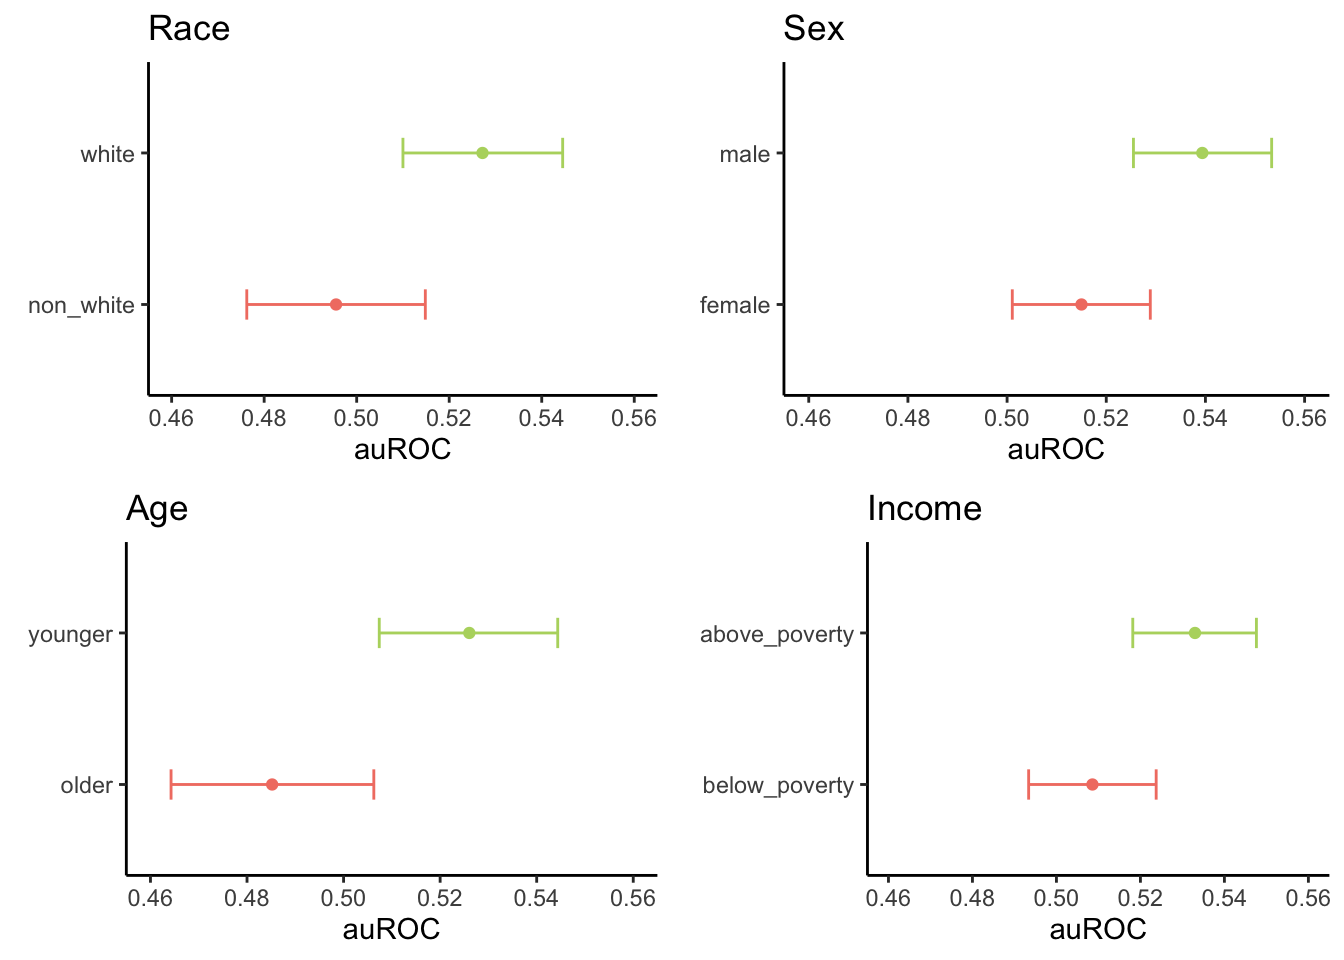

In [ ]:

ggpubr::ggarrange(
  bayes_output(pp_race) |> 
    ggplot(aes(y = factor(model, levels = c("non_white", "white")), 
               x = median, color = model)) + 
    geom_point() +
    geom_errorbar(aes(xmin = lower, xmax = upper), width = .2) +
    scale_color_manual(values = c("#F28072", "#B5D66E")) +
    labs(x = "auROC", y = element_blank(), title = "Race") +
    scale_x_continuous(limits = c(0.46, 0.56), 
                       breaks = seq(0.46, 0.58, by = 0.02)) +
    theme(legend.position = "none"),
  bayes_output(pp_sex) |> 
    ggplot(aes(y = factor(model, levels = c("female", "male")), 
               x = median, color = model)) + 
    geom_point() +
    geom_errorbar(aes(xmin = lower, xmax = upper), width = .2) +
    scale_color_manual(values = c("#F28072", "#B5D66E")) +
    labs(x = "auROC", y = element_blank(), title = "Sex") +
    scale_x_continuous(limits = c(0.46, 0.56), 
                       breaks = seq(0.46, 0.58, by = 0.02)) +
    theme(legend.position = "none"),
  bayes_output(pp_age) |> 
    ggplot(aes(y = factor(model, levels = c("older", "younger")), 
               x = median, color = model)) + 
    geom_point() +
    geom_errorbar(aes(xmin = lower, xmax = upper), width = .2) +
    scale_color_manual(values = c("#F28072", "#B5D66E")) +
    labs(x = "auROC", y = element_blank(), title = "Age") +
    scale_x_continuous(limits = c(0.46, 0.56), 
                       breaks = seq(0.46, 0.58, by = 0.02)) +
    theme(legend.position = "none"),
  bayes_output(pp_income) |> 
    ggplot(aes(y = factor(model, levels = c("below_poverty", "above_poverty")), 
               x = median, color = model)) + 
    geom_point() +
    geom_errorbar(aes(xmin = lower, xmax = upper), width = .2) +
    scale_color_manual(values = c("#B5D66E", "#F28072")) +
    labs(x = "auROC", y = element_blank(), title = "Income") +
    scale_x_continuous(limits = c(0.46, 0.56), 
                       breaks = seq(0.46, 0.58, by = 0.02)) +
    theme(legend.position = "none")
)


## Model Comparison

In [ ]:
pp_race |> 
  contrast_models("white", "non_white") |>
  summarize(
    median = quantile(difference, probs = .5),
    lower = quantile(difference, probs = .025), 
    upper = quantile(difference, probs = .975),
    prob = mean(difference > 0)
    ) |> 
  mutate(group = "white vs. non_white") |> 
  relocate(group) |> 
  bind_rows(
    pp_sex |> 
      contrast_models("male", "female") |>
      summarize(
        median = quantile(difference, probs = .5),
        lower = quantile(difference, probs = .025), 
        upper = quantile(difference, probs = .975),
        prob = mean(difference > 0)
        ) |> 
      mutate(group = "male vs. female") |> 
      relocate(group)
  ) |> 
  bind_rows(
    pp_age |> 
      contrast_models("younger", "older") |>
      summarize(
        median = quantile(difference, probs = .5),
        lower = quantile(difference, probs = .025), 
        upper = quantile(difference, probs = .975),
        prob = mean(difference > 0)
        ) |> 
      mutate(group = "younger vs. older") |> 
      relocate(group)
  ) |> 
  bind_rows(
    pp_income |> 
      contrast_models("above_poverty", "below_poverty") |>
      summarize(
        median = quantile(difference, probs = .5),
        lower = quantile(difference, probs = .025), 
        upper = quantile(difference, probs = .975),
        prob = mean(difference > 0)
        ) |> 
      mutate(group = "above_poverty vs. below_poverty") |> 
      relocate(group)
  ) |> 
  write_csv(here("_csv/subgroup_comparison.csv"))
